# MSc Thesis - Hugo Stam

### Example 02 - Offshore Port System - Barges

<img src="Figures/system_layout_alternative_2.2.png" style="width:1000px">

##### Investment Strategy Simulation - Adaptive terminal planning in the light of an uncertain future

* [**0. Prepare inputs:**](#0.-Prepare-inputs)<br>
   * [**0.1 Generate demand forecast scenario:**](#0.1-Generate-demand-forecast-scenario)<br>
   * [**0.2 Generate vessels:**](#0.2-Generate-vessels)<br>
* [**1. Instatiate system components:**](#1.-Instatiate-system-components)<br>
* [**2. Start simulation:**](#2.-Strart-simulation)<br>
* [**3. Report all elements:**](#3.-Report-all-elements)<br>

#### notes:


In [1]:
# packages for data handling
import numpy as np
import pandas as pd
import statistics as st

# packages related to time, space and id
import datetime, time
import platform
import random
from datetime import timedelta

# you need these dependencies packages related to the simulation
import simpy

# spatial libraries 
import shapely.geometry
from simplekml import Kml, Style

# packages for figures
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
# %matplotlib inline
%matplotlib notebook

import seaborn as sns
sns.set(style="ticks")
# sns.set_style("whitegrid")
# sns.set(style="darkgrid", palette = "pastel")
# sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.5})

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# OpenTISim package
from opentisim import container_objects
from opentisim import container_defaults
from opentisim import container_system_offshore_barge

# OpenCLSim package
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

# Additional import to save the initialisation of the simulation
import openclsim.savesim as savesim

# Pretty-print a Python object to a stream
from pprint import pprint

# Jupyter Widgets
import ipywidgets as widgets

# 
from IPython.display import HTML

# Scroll to specific cell
from jupyter_helpers.utilities import scroll_to_current_cell

# 0. Prepare inputs

In [2]:
# scroll_to_current_cell(preserve=True)

In [3]:
# iPython Widgests
annual_demand = widgets.IntSlider(
    value=1000000, min=500000, max=1500000, step=50000,
    description='Demand:', orientation='horizontal',
    readout=True, readout_format='d')

offshore_onshore_distance = widgets.IntSlider(
    value=40, min=20, max=60, step=20,
    description='Distance:', orientation='horizontal',
    readout=True, readout_format='d')

container_ship = widgets.Dropdown(
    options=[('Post Panamax I (6,000 TEU)', 6000),
             ('New-Panamax (12,500 TEU)', 12500),
             ('ULCS (21,000 TEU)', 21000)],
    value=12500,
    description='OGV:')

barge = widgets.Dropdown(
    options=[('Small (200 TEU)', 200),
             ('Medium (250 TEU)', 250),
             ('Large (300 TEU)', 300)],
    value=250,
    description='Barge:')

life_cycle = widgets.IntSlider(
    value=10, min=10, max=30, step=5,
    description='Life cycle:', orientation='horizontal',
    readout=True, readout_format='d')

print('\033[1m*** Input Values \033[0m')
display(annual_demand, offshore_onshore_distance, container_ship, barge, life_cycle)

*** Input Values 


IntSlider(value=1000000, description='Demand:', max=1500000, min=500000, step=50000)

IntSlider(value=40, description='Distance:', max=60, min=20, step=20)

Dropdown(description='OGV:', index=1, options=(('Post Panamax I (6,000 TEU)', 6000), ('New-Panamax (12,500 TEU…

Dropdown(description='Barge:', index=1, options=(('Small (200 TEU)', 200), ('Medium (250 TEU)', 250), ('Large …

IntSlider(value=10, description='Life cycle:', max=30, min=10, step=5)

In [4]:
offshore_distance = offshore_onshore_distance.value
demand = annual_demand.value
design_container_ship = container_ship.value
design_barge = barge.value
lifecycle = life_cycle.value

print('The offshore distance:', offshore_distance, 'km')
print('The annual demand:', demand, 'TEU')
print('The design container ship capacity:', design_container_ship, 'TEU')
print('The design barge capacity:', design_barge, 'TEU')
print('The design life cycle:', lifecycle, 'years')

avg_parcel = design_container_ship / 8

startyear = 2020

The offshore distance: 40 km
The annual demand: 1000000 TEU
The design container ship capacity: 12500 TEU
The design barge capacity: 250 TEU
The design life cycle: 10 years


## 0.1 Generate demand forecast scenario

11


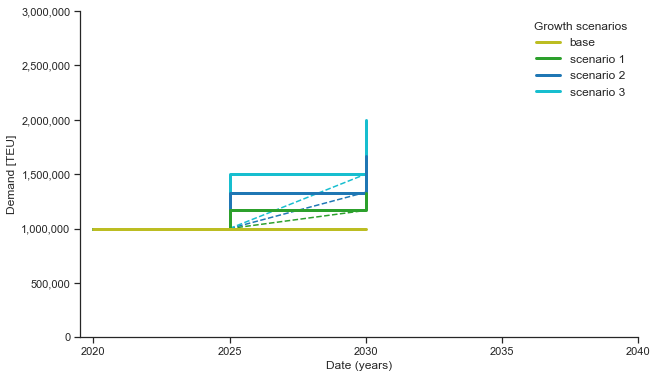

In [5]:
container = demand  # TEU
years = list(range(startyear, startyear+lifecycle+1))
print(len(years))
trend_2 = []
trend_3 = []
trend_4 = []

for i in range(lifecycle-4):
    trend_2.append(container +   500_000/15 * i)
    trend_3.append(container + 1_000_000/15 * i)
    trend_4.append(container + 1_500_000/15 * i)

demand_1 = []
demand_2 = []
demand_3 = []
demand_4 = []

for year in years:
    if year < 2025:
        demand_1.append(int(container * 1.00))
        demand_2.append(int(container * 1.00))
        demand_3.append(int(container * 1.00))
        demand_4.append(int(container * 1.00))
        
    elif year < 2030:
        demand_1.append(int(container * 1.00))
        demand_2.append(int(container * 1.17))
        demand_3.append(int(container * 1.33))
        demand_4.append(int(container * 1.50))
    elif year < 2035:
        demand_1.append(int(container * 1.00))
        demand_2.append(int(container * 1.33))
        demand_3.append(int(container * 1.67))
        demand_4.append(int(container * 2.00))
    else:
        demand_1.append(int(container * 1.00))
        demand_2.append(int(container * 1.50))
        demand_3.append(int(container * 2.00))
        demand_4.append(int(container * 2.50))

# figure 
plt.figure(figsize=(10,6))

plt.plot(years[5:lifecycle+1], trend_2, color='tab:green', linestyle='--', zorder=0)
plt.plot(years[5:lifecycle+1], trend_3, color='tab:blue' , linestyle='--', zorder=0)
plt.plot(years[5:lifecycle+1], trend_4, color='tab:cyan' , linestyle='--', zorder=0)

plt.step(years, demand_1, color='tab:olive', linewidth=3, label='base', where='post', zorder=4)
plt.step(years, demand_2, color='tab:green', linewidth=3, label='scenario 1', where='post', zorder=3)
plt.step(years, demand_3, color='tab:blue' , linewidth=3, label='scenario 2', where='post', zorder=2)
plt.step(years, demand_4, color='tab:cyan' , linewidth=3, label='scenario 3', where='post', zorder=1)

plt.xticks([2020, 2025, 2030, 2035, 2040])
plt.xlabel("Date (years)", fontsize='large')

plt.yticks([0, 0.5e6, 1e6, 1.5e6, 2e6, 2.5e6, 3e6],
           [0, '500,000', '1,000,000', '1,500,000', '2,000,000', '2,500,000', '3,000,000'])
plt.ylabel('Demand [TEU]', fontsize='large')

plt.legend(loc='best', title='Growth scenarios', title_fontsize='large', fontsize='large', frameon=False)

# figure aesthetics
plt.grid(False, which='major')
sns.despine(top=True)

# save fig
plt.savefig("SaveFigures/growth_scenarios.png")

In [6]:
if lifecycle == 20:
    years = years[0:20]
    demand_1 = demand_1[0:20]
    demand_2 = demand_2[0:20]
    demand_3 = demand_3[0:20]
    demand_4 = demand_4[0:20]
    
if lifecycle == 10:
    years = years[0:10]
    demand_1 = demand_1[0:10]
    demand_2 = demand_2[0:10]
    demand_3 = demand_3[0:10]
    demand_4 = demand_4[0:10]

print('Years:', len(years), years)    
print('Demand:',len(demand_3), demand_3)

Years: 10 [2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029]
Demand: 10 [1000000, 1000000, 1000000, 1000000, 1000000, 1330000, 1330000, 1330000, 1330000, 1330000]


In [7]:
years = list(range(startyear, startyear + lifecycle))
        
scenario_data={'year': years, 'volume': demand_3}
# print(scenario_data)

# instantiate Commodity objects, the inputs for the Commodity class
if design_container_ship == 6000:
    container_defaults.container_data['post_panamax_I_perc'] = 100
    container_defaults.container_data['new_panamax_perc'] = 0
    container_defaults.container_data['ULCS_perc'] = 0

if design_container_ship == 12500:
    container_defaults.container_data['post_panamax_I_perc'] = 0
    container_defaults.container_data['new_panamax_perc'] = 100
    container_defaults.container_data['ULCS_perc'] = 0
    
if design_container_ship == 21000:
    container_defaults.container_data['post_panamax_I_perc'] = 0
    container_defaults.container_data['new_panamax_perc'] = 0
    container_defaults.container_data['ULCS_perc'] = 100
    
# print(container_defaults.container_data)

# ladens
container = container_objects.Commodity(**container_defaults.container_data)
container.scenario_data = pd.DataFrame(data=scenario_data)
# print(container)
# print(container.scenario_data)

# combine
demand = [container]

## 0.2 Generate vessels

In [8]:
# instantiate vessels
fully_cellular = container_objects.Vessel(**container_defaults.fully_cellular_data)
panamax = container_objects.Vessel(**container_defaults.panamax_data)
panamax_max = container_objects.Vessel(**container_defaults.panamax_max_data)
post_panamax_I = container_objects.Vessel(**container_defaults.post_panamax_I_data)
post_panamax_II = container_objects.Vessel(**container_defaults.post_panamax_II_data)
new_panamax = container_objects.Vessel(**container_defaults.new_panamax_data)
VLCS = container_objects.Vessel(**container_defaults.VLCS_data)
ULCS = container_objects.Vessel(**container_defaults.ULCS_data)

vessels = [fully_cellular, panamax, panamax_max, post_panamax_I, post_panamax_II, new_panamax, VLCS, ULCS] 

# 1. Instatiate system components

## 1.1 Terminal system

Specify the variables

In [9]:
OffshoreBarge = container_system_offshore_barge.System(
                startyear = startyear,
                lifecycle = lifecycle,
                stack_equipment = 'rmg',
                laden_stack = 'rmg',
                elements = demand + vessels,
                crane_type_defaults = container_defaults.sts_crane_data,
                offshore_distance = offshore_distance,
                barge_type = 'medium',
                bathymetry_factor = 0.85,
                allowable_berth_occupancy = 0.50,
                laden_perc=0.80, 
                reefer_perc=0.10,
                empty_perc=0.05, 
                oog_perc=0.05,
                transhipment_ratio = 0.10,
                debug = True)

# 2. Start simulation

This method automatically generates investment decisions, parametrically derived from demand trends and a number of investment triggers.

Apply frame of reference style decisions while stepping through each year of the terminal lifecycle and check if investment is needed (in light of strategic objective, operational objective, QSC, decision recipe, intervention method):
    1. for each year evaluate the demand of each commodity (see 0.1 Demand forecast scenario)
    2. for each year evaluate the various investment decisions
    3. for each year calculate the energy costs (requires insight in realized demands)
    4. for each year calculate the demurrage costs (requires insight in realized demands)
    5. for each year calculate terminal revenues
    6. collect all cash flows (capex, opex, {revenues})
    7. calculate PV's {and aggregate to NPV}

In [10]:
OffshoreBarge.simulate()


Offshore Port System - Barge Connection

Below, the various investment decisions are evaluated for the year 2020.

Simulate year: 2020
  Total vessel calls: 640
  Fully cellular calls: 0
  Panamax calls: 0
  Panamax max calls: 0
  Post Panamax I calls: 0
  Post Panamax II calls: 0
  New Panamax calls: 640
  VLCS calls: 0
  ULCS calls: 0
  Total cargo volume: 1000000
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned

  Start analysis:
     Berth occupancy planned (@ start of year): inf
     Berth occupancy online  (@ start of year): inf
     Crane occupancy planned (@ start of year): inf
     Crane occupancy online  (@ start of year): inf

  *** add Berth to elements
     Berth occupancy planned (after adding Berth): inf
     Berth occupancy online  (after adding Berth): inf

*** nr of berths: 1
quay_length_in_func 430 m
quay_depth 17 m
  *** add Quay to elements
df    Year  Offshore Terminal 

df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020               25741930.2            4.290322e+07   
1  2021               17161286.8            2.860214e+07   
2  2022                      0.0            0.000000e+00   
3  2023                      0.0            0.000000e+00   
4  2024                      0.0            0.000000e+00   

   Offshore Maintenance  Onshore Maintenance  Offshore Insurance  \
0                 0.000                0.000               0.000   
1                 0.000                0.000               0.000   
2            366656.235           611093.725          366656.235   
3            366656.235           611093.725          366656.235   
4            366656.235           611093.725          366656.235   

   Onshore Insurance  
0              0.000  
1              0.000  
2         611093.725  
3         611093.725  
4         611093.725  
     Berth occupancy planned (after adding Quay): 0.741
     Berth occupancy online  (aft

c:\checkouts\opentisim\opentisim\container_system_offshore_barge.py:1839: FutureWarning:

`item` has been deprecated and will be removed in a future version



    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0            0.000000e+00   
1  2021               11500000.0            1.916667e+07   
2  2022                      0.0            0.000000e+00   
3  2023                      0.0            0.000000e+00   
4  2024                      0.0            0.000000e+00   

   Offshore Maintenance  Onshore Maintenance  Offshore Insurance  \
0                   0.0             0.000000                 0.0   
1                   0.0             0.000000                 0.0   
2              200000.0        333333.333333            100000.0   
3              200000.0        333333.333333            100000.0   
4              200000.0        333333.333333            100000.0   

   Onshore Insurance  Offshore Labour  Onshore Labour  
0           0.000000         0.000000    0.000000e+00  
1           0.000000         0.000000    0.000000e+00  
2      166666.666667    793269.230769    1.322115e+06  
3    

c:\checkouts\opentisim\opentisim\container_system_offshore_barge.py:2350: FutureWarning:

`item` has been deprecated and will be removed in a future version

c:\checkouts\opentisim\opentisim\container_system_offshore_barge.py:1915: FutureWarning:

`item` has been deprecated and will be removed in a future version



    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0            0.000000e+00   
1  2021                3700358.0            6.167263e+06   
2  2022                      0.0            0.000000e+00   
3  2023                      0.0            0.000000e+00   
4  2024                      0.0            0.000000e+00   

   Offshore Maintenance  Onshore Maintenance  
0                   0.0             0.000000  
1                   0.0             0.000000  
2              312535.0        520891.666667  
3              312535.0        520891.666667  
4              312535.0        520891.666667  
  *** add Laden Stack to elements
df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0            0.000000e+00   
1  2021                3700358.0            6.167263e+06   
2  2022                      0.0            0.000000e+00   
3  2023                      0.0            0.000000e+00   
4  2024            

4               73440.0             122400.0  
  *** add Empty Stack to elements
df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0            0.000000e+00   
1  2021                 759400.0            1.265667e+06   
2  2022                      0.0            0.000000e+00   
3  2023                      0.0            0.000000e+00   
4  2024                      0.0            0.000000e+00   

   Offshore Maintenance  Onshore Maintenance  
0                   0.0                  0.0  
1                   0.0                  0.0  
2               73440.0             122400.0  
3               73440.0             122400.0  
4               73440.0             122400.0  
     OOG Slots planned  (@ start of year): 0
     OOG Slots online   (@ start of year): 0
     OOG Slots required (@ start of year): 524

  *** add OOG stack to elements
df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0        

df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                     0.0   
1  2021                 107187.0                178645.0   
2  2022                      0.0                     0.0   
3  2023                      0.0                     0.0   
4  2024                      0.0                     0.0   

   Offshore Maintenance  Onshore Maintenance  Offshore Labour  Onshore Labour  
0                   0.0                  0.0              0.0        0.000000  
1                   0.0                  0.0              0.0        0.000000  
2                 600.0               1000.0         250000.0   416666.666667  
3                 600.0               1000.0         250000.0   416666.666667  
4                 600.0               1000.0         250000.0   416666.666667  
  *** add Gate to elements
df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                     0.0   
1  202

df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020               18000000.0              30000000.0   
1  2021               12000000.0              20000000.0   
2  2022                      0.0                     0.0   
3  2023                      0.0                     0.0   
4  2024                      0.0                     0.0   

   Offshore Maintenance  Onshore Maintenance  
0                   0.0                  0.0  
1                   0.0                  0.0  
2                 600.0               1000.0  
3                 600.0               1000.0  
4                 600.0               1000.0  
     Barge Capacity planned  (@ start of year): 0
     Barge Capacity online   (@ start of year): 0
     Barge Capacity required (@ start of year): 725000

  *** add Barge to elements
df    Year
0  2020
1  2021
2  2022
3  2023
4  2024
barges_online 1
  *** add Barge to elements
df    Year  Barge Capex  Barge Opex
0  2020          0.0         0.0
1  202

4                 600.0               1000.0  
  *** add Onshore Barge Berth to elements
df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020               18000000.0              30000000.0   
1  2021               12000000.0              20000000.0   
2  2022                      0.0                     0.0   
3  2023                      0.0                     0.0   
4  2024                      0.0                     0.0   

   Offshore Maintenance  Onshore Maintenance  
0                   0.0                  0.0  
1                   0.0                  0.0  
2                 600.0               1000.0  
3                 600.0               1000.0  
4                 600.0               1000.0  
  *** add Onshore Barge Berth to elements
df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020               18000000.0              30000000.0   
1  2021               12000000.0              20000000.0   
2  2022                      0.0        

df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                0.000000   
1  2021                 505000.0           841666.666667   
2  2022                      0.0                0.000000   
3  2023                      0.0                0.000000   
4  2024                      0.0                0.000000   

   Offshore Maintenance  Onshore Maintenance  Offshore Labour  Onshore Labour  
0                   0.0             0.000000         0.000000        0.000000  
1                   0.0             0.000000         0.000000        0.000000  
2               10000.0         16666.666667    144230.769231   240384.615385  
3               10000.0         16666.666667    144230.769231   240384.615385  
4               10000.0         16666.666667    144230.769231   240384.615385  
  *** add Tractor to elements
df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                0.000000   
1  

df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                0.000000   
1  2021                 505000.0           841666.666667   
2  2022                      0.0                0.000000   
3  2023                      0.0                0.000000   
4  2024                      0.0                0.000000   

   Offshore Maintenance  Onshore Maintenance  Offshore Labour  Onshore Labour  
0                   0.0             0.000000         0.000000        0.000000  
1                   0.0             0.000000         0.000000        0.000000  
2               10000.0         16666.666667    144230.769231   240384.615385  
3               10000.0         16666.666667    144230.769231   240384.615385  
4               10000.0         16666.666667    144230.769231   240384.615385  
  *** add Tractor to elements
df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                0.000000   
1  

df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                0.000000   
1  2021                 505000.0           841666.666667   
2  2022                      0.0                0.000000   
3  2023                      0.0                0.000000   
4  2024                      0.0                0.000000   

   Offshore Maintenance  Onshore Maintenance  Offshore Labour  Onshore Labour  
0                   0.0             0.000000         0.000000        0.000000  
1                   0.0             0.000000         0.000000        0.000000  
2               10000.0         16666.666667    144230.769231   240384.615385  
3               10000.0         16666.666667    144230.769231   240384.615385  
4               10000.0         16666.666667    144230.769231   240384.615385  
  *** add Tractor to elements
df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                0.000000   
1  

df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0            0.000000e+00   
1  2021               33319000.0            5.553167e+07   
2  2022                      0.0            0.000000e+00   
3  2023                      0.0            0.000000e+00   
4  2024                      0.0            0.000000e+00   

   Offshore Maintenance  Onshore Maintenance  
0                   0.0                  0.0  
1                   0.0                  0.0  
2              499785.0             832975.0  
3              499785.0             832975.0  
4              499785.0             832975.0  

Offshore Port System - Barge Connection

Below, the various investment decisions are evaluated for the year 2022.

Simulate year: 2022
  Total vessel calls: 640
  Fully cellular calls: 0
  Panamax calls: 0
  Panamax max calls: 0
  Post Panamax I calls: 0
  Post Panamax II calls: 0
  New Panamax calls: 640
  VLCS calls: 0
  ULCS calls: 0
  Total cargo 

4                8500.0         14166.666667    144230.769231   240384.615385  
  *** add Tractor to elements
df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                0.000000   
1  2021                  86000.0           143333.333333   
2  2022                      0.0                0.000000   
3  2023                      0.0                0.000000   
4  2024                      0.0                0.000000   

   Offshore Maintenance  Onshore Maintenance  Offshore Labour  Onshore Labour  
0                   0.0             0.000000         0.000000        0.000000  
1                   0.0             0.000000         0.000000        0.000000  
2                8500.0         14166.666667    144230.769231   240384.615385  
3                8500.0         14166.666667    144230.769231   240384.615385  
4                8500.0         14166.666667    144230.769231   240384.615385  
  *** add Tractor to elements
df    Year  Offs

4                8500.0         14166.666667    144230.769231   240384.615385  
  *** add Tractor to elements
df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                0.000000   
1  2021                  86000.0           143333.333333   
2  2022                      0.0                0.000000   
3  2023                      0.0                0.000000   
4  2024                      0.0                0.000000   

   Offshore Maintenance  Onshore Maintenance  Offshore Labour  Onshore Labour  
0                   0.0             0.000000         0.000000        0.000000  
1                   0.0             0.000000         0.000000        0.000000  
2                8500.0         14166.666667    144230.769231   240384.615385  
3                8500.0         14166.666667    144230.769231   240384.615385  
4                8500.0         14166.666667    144230.769231   240384.615385  
  *** add Tractor to elements
df    Year  Offs

df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                0.000000   
1  2021                  86000.0           143333.333333   
2  2022                      0.0                0.000000   
3  2023                      0.0                0.000000   
4  2024                      0.0                0.000000   

   Offshore Maintenance  Onshore Maintenance  Offshore Labour  Onshore Labour  
0                   0.0             0.000000         0.000000        0.000000  
1                   0.0             0.000000         0.000000        0.000000  
2                8500.0         14166.666667    144230.769231   240384.615385  
3                8500.0         14166.666667    144230.769231   240384.615385  
4                8500.0         14166.666667    144230.769231   240384.615385  
  *** add Tractor to elements
df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                0.000000   
1  

df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                     0.0   
1  2021                2505000.0               4175000.0   
2  2022                      0.0                     0.0   
3  2023                      0.0                     0.0   
4  2024                      0.0                     0.0   

   Offshore Maintenance  Onshore Maintenance  
0                   0.0             0.000000  
1                   0.0             0.000000  
2              250000.0        416666.666667  
3              250000.0        416666.666667  
4              250000.0        416666.666667  
  *** add Stack Equipment to elements
df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                     0.0   
1  2021                2505000.0               4175000.0   
2  2022                      0.0                     0.0   
3  2023                      0.0                     0.0   
4  2024      

df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                     0.0   
1  2021                      0.0                     0.0   
2  2022                      0.0                     0.0   
3  2023                      0.0                     0.0   
4  2024                      0.0                     0.0   

   Offshore Maintenance  Onshore Maintenance  Offshore Insurance  \
0                   0.0                  0.0                 0.0   
1                   0.0                  0.0                 0.0   
2                   0.0                  0.0                 0.0   
3                   0.0                  0.0                 0.0   
4                   0.0                  0.0                 0.0   

   Onshore Insurance  Offshore Labour  Onshore Labour  
0                0.0              0.0             0.0  
1                0.0              0.0             0.0  
2                0.0              0.0             0.0  
3  

df    Year  Barge Capex  Barge Opex
0  2020          0.0         0.0
1  2021          0.0         0.0
2  2022          0.0         0.0
3  2023          0.0         0.0
4  2024          0.0         0.0
barges_online 25
  *** add Barge to elements
df    Year  Barge Capex  Barge Opex
0  2020          0.0         0.0
1  2021          0.0         0.0
2  2022          0.0         0.0
3  2023          0.0         0.0
4  2024          0.0         0.0
barges_online 26
length 100
draught 5.0
beam 13.0
     Onshore barge berth capacity planned (@ start of year): 852936.6000000004 TEU/yr
     Onshore Barge berth capacity online (@ start of year): 852936.6000000004 TEU/yr
     Onshore Barge berth service rate planned (@ start of year): 1.169489033534262
     Onshore Barge berth capacity required (@ start of year): 997500.0 TEU/yr

  *** add Onshore Barge Berth to elements
df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                     0.0   
1  20

df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                     0.0   
1  2021                      0.0                     0.0   
2  2022                      0.0                     0.0   
3  2023                      0.0                     0.0   
4  2024                      0.0                     0.0   

   Offshore Maintenance  Onshore Maintenance  Offshore Labour  Onshore Labour  
0                   0.0                  0.0              0.0             0.0  
1                   0.0                  0.0              0.0             0.0  
2                   0.0                  0.0              0.0             0.0  
3                   0.0                  0.0              0.0             0.0  
4                   0.0                  0.0              0.0             0.0  
  *** add Tractor to elements
df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                     0.0   
1  

df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                     0.0   
1  2021                      0.0                     0.0   
2  2022                      0.0                     0.0   
3  2023                      0.0                     0.0   
4  2024                      0.0                     0.0   

   Offshore Maintenance  Onshore Maintenance  
0                   0.0                  0.0  
1                   0.0                  0.0  
2                   0.0                  0.0  
3                   0.0                  0.0  
4                   0.0                  0.0  
  *** add Stack Equipment to elements
df    Year  Offshore Terminal Capex  Onshore Terminal Capex  \
0  2020                      0.0                     0.0   
1  2021                      0.0                     0.0   
2  2022                      0.0                     0.0   
3  2023                      0.0                     0.0   
4  2024      

c:\checkouts\opentisim\opentisim\container_system_offshore_barge.py:504: FutureWarning:

`item` has been deprecated and will be removed in a future version



container_ship_costs 60,000,000 USD
container_ship_costs 60,000,000 USD
container_ship_costs 60,000,000 USD
container_ship_costs 60,000,000 USD
container_ship_costs 60,000,000 USD
container_ship_costs 79,800,000 USD
container_ship_costs 79,800,000 USD
container_ship_costs 79,800,000 USD
container_ship_costs 79,800,000 USD
container_ship_costs 79,800,000 USD


## 3. Report all elements

In [11]:
if True: 
    for element in OffshoreBarge.elements:
        print("")
        print(element.name)
        print("")
        print(element.__dict__) # This is the dictionary containing the module's symbol table.


Laden

{'historic_data': [], 'scenario_data':    year   volume
0  2020  1000000
1  2021  1000000
2  2022  1000000
3  2023  1000000
4  2024  1000000
5  2025  1330000
6  2026  1330000
7  2027  1330000
8  2028  1330000
9  2029  1330000, 'handling_fee': 150, 'fully_cellular_perc': 0, 'panamax_perc': 0, 'panamax_max_perc': 0, 'post_panamax_I_perc': 0, 'post_panamax_II_perc': 0, 'new_panamax_perc': 100, 'VLCS_perc': 0, 'ULCS_perc': 0, 'name': 'Laden', 'id': '0c2e8966-53fa-11ea-92cc-04d3b0b539c4'}

Fully_Cellular_1

{'type': 'Fully_Cellular', 'starting_time': 0, 'call_size': 312.5, 'LOA': 215, 'draught': 10.0, 'beam': 20.0, 'max_cranes': 4, 'all_turn_time': 31, 'mooring_time': 6, 'demurrage_rate': 730, 'transport_costs': 200, 'year_purchase': [], 'year_online': [], 'name': 'Fully_Cellular_1', 'id': '0c2fc252-53fa-11ea-b168-04d3b0b539c4'}

Panamax_1

{'type': 'Panamax', 'starting_time': 0, 'call_size': 425.0, 'LOA': 250, 'draught': 12.5, 'beam': 32.2, 'max_cranes': 4, 'all_turn_time': 31, 'mo

9  1091.561538  }

Empty Handler

{'triggers': [], 'labour': 144230.76923076922, 'maintenance': 10000.0, 'energy': [], 'insurance': [], 'fuel': [], 'demurrage': [], 'ocean_transport': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'structure_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': [], 'truck_maintenace': [], 'off_terminal_capex': 505000, 'on_terminal_capex': [], 'capital_dredging': [], 'bridge_construction': [], 'island_construction': [], 'coastal_protection_construction': [], 'barge_capex': [], 'truck_capex': [], 'type': 'empty_handler', 'ownership': 'Terminal operator', 'delivery_time': 1, 'lifespan': 15, 'unit_rate': 500000, 'mobilisation': 5000, 'maintenance_perc': 0.02, 'crew': 1, 'salary': 35000, 'fuel_consumption': 1.5, 'required': 5, 'year_purchase': [], 'year_online': 2022, 'name': 'Empty Handler', 'id': '0d000496-53fa-11ea-b808-04d3b0b539c4', 'shift': 5.769230769230769, 'df':    Year  Offshore Terminal Capex  Onshore Terminal Capex

9               73440.0             122400.0  }

Empty Stack

{'land_use': 2937.6, 'triggers': [], 'off_terminal_capex': 759400, 'on_terminal_capex': [], 'capital_dredging': [], 'bridge_construction': [], 'island_construction': [], 'coastal_protection_construction': [], 'barge_capex': [], 'truck_capex': [], 'labour': [], 'maintenance': 73440, 'energy': [], 'insurance': [], 'fuel': [], 'demurrage': [], 'ocean_transport': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'structure_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': [], 'truck_maintenace': [], 'ownership': 'Terminal operator', 'delivery_time': 1, 'lifespan': 40, 'mobilisation': 25000, 'maintenance_perc': 0.1, 'width': 8, 'height': 6, 'length': 10, 'capacity': 480, 'gross_tgs': 18, 'area_factor': 2.04, 'pavement': 200, 'drainage': 50, 'household': 1.05, 'digout': 1.05, 'year_purchase': [], 'year_online': 2026, 'name': 'Empty Stack', 'id': '0e061b4e-53fa-11ea-ba57-04d3b0b539c4', 'storage_area'

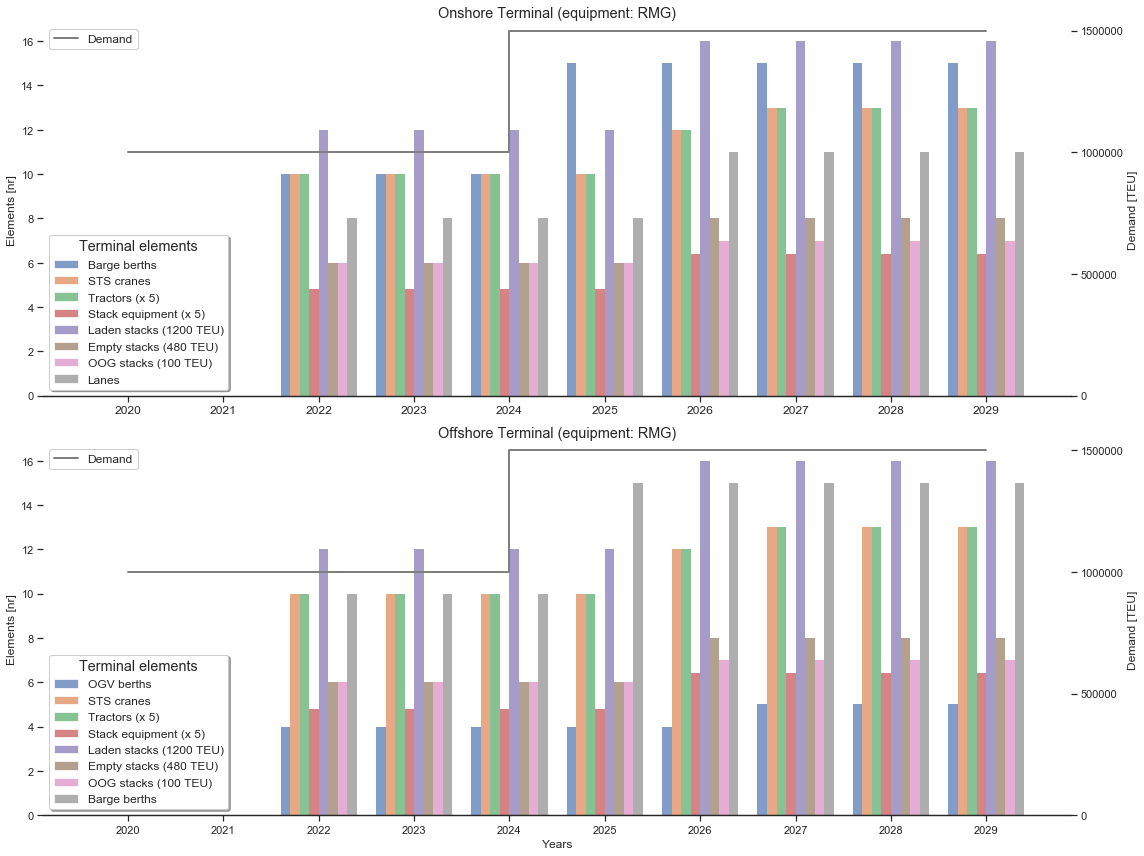

In [12]:
OffshoreBarge.terminal_elements_plot()
sns.despine(left=True)

# save fig
# plt.savefig("SaveFigures/terminal_elements_alt2.png")
plt.savefig("SaveFigures/terminal_elements_alt2_example.png")

In [13]:
# OffshoreBarge.terminal_capacity_plot()
# sns.despine(left=True)

In [14]:
# OffshoreBarge.terminal_land_use_plot()
# sns.despine(left=True)

In [15]:
# OffshoreBarge.storage_area_plot()

# # save fig
# plt.savefig("SaveFigures/storage_area_ex2.png")

#### Add cash flow information for each of the terminal elements.

In [16]:
cash_flows_df, cash_flows_WACC_real_df = OffshoreBarge.add_cashflow_elements()
display(cash_flows_df.style.hide_index())

Year,Reclamation,Coastal Protection,Coastal Structures Maintenance,Offshore Terminal Capex,Offshore Maintenance,Offshore Insurance,Offshore Energy,Offshore Labour,Offshore Fuel,Offshore Terminal Opex,Onshore Terminal Capex,Onshore Maintenance,Onshore Insurance,Onshore Energy,Onshore Labour,Onshore Fuel,Onshore Terminal Opex,Ocean Transport,Barge Capex,Barge Opex,Capital Dredging,Maintenance Dredging
2020,4.5e+07,2.73e+08,0,3.54968e+08,0,0,0,0,0,0,5.91613e+08,0,0,0,0,0,0,0,0,0,2.73792e+08,0
2021,6.75e+07,4.095e+08,0,5.34682e+08,0,0,0,0,0,0,8.91137e+08,0,0,0,0,0,0,0,1.9e+08,0,2.73792e+08,0
2022,0,0,4.1295e+06,0,1.61037e+07,2.46662e+06,0,2.43558e+07,0,0,0,2.68394e+07,4.11104e+06,0,4.05929e+07,0,0,0,0,1.9e+07,0,1.9713e+07
2023,0,0,4.1295e+06,0,1.61037e+07,2.46662e+06,0,2.43558e+07,0,0,0,2.68394e+07,4.11104e+06,0,4.05929e+07,0,0,0,0,1.9e+07,0,1.9713e+07
2024,0,0,4.1295e+06,0,1.61037e+07,2.46662e+06,0,2.43558e+07,0,0,0,2.68394e+07,4.11104e+06,0,4.05929e+07,0,0,0,0,1.9e+07,0,1.9713e+07
2025,0,0,4.1295e+06,1.67564e+08,1.61037e+07,2.46662e+06,0,2.43558e+07,0,0,2.79273e+08,2.68394e+07,4.11104e+06,0,4.05929e+07,0,0,0,1.35e+08,1.9e+07,0,1.9713e+07
2026,0,0,4.1295e+06,7.70913e+07,2.03055e+07,2.66662e+06,0,3.02981e+07,0,0,1.28485e+08,3.38425e+07,4.44437e+06,0,5.04968e+07,0,0,0,0,3.25e+07,0,1.9713e+07
2027,0,0,4.1295e+06,0,2.0917e+07,3.13328e+06,0,3.18125e+07,0,0,0,3.48617e+07,5.22214e+06,0,5.30208e+07,0,0,0,0,3.25e+07,0,1.9713e+07
2028,0,0,4.1295e+06,0,2.0917e+07,3.13328e+06,0,3.18125e+07,0,0,0,3.48617e+07,5.22214e+06,0,5.30208e+07,0,0,0,0,3.25e+07,0,1.9713e+07
2029,0,0,4.1295e+06,0,2.0917e+07,3.13328e+06,0,3.18125e+07,0,0,0,3.48617e+07,5.22214e+06,0,5.30208e+07,0,0,0,0,3.25e+07,0,1.9713e+07


In [17]:
(island_construction, coastal_protection_construction, offshore_maintenance,
 off_terminal_capex, terminal_opex, capital_dredging, maintenance_dredging, 
 ocean_transport, barge_capex, barge_opex, cash_flows, cash_flows_df, cash_flows_WACC_real_df, PV
 ) = OffshoreBarge.net_present_value()

In [18]:
# OffshoreBarge.terminal_opex_plot(cash_flows_df)
# sns.despine(left=True)

In [19]:
print('\033[1m    Financial Indication\033[0m')
print(' ** PV of the costs: ${}'.format(f'{round(PV,-6):,}'))

# hide_columns_list = ['Offshore Maintenance', 'Offshore Insurance', 'Offshore Energy', 
#                      'Offshore Labour', 'Offshore Fuel', 'Offshore Demurrage']
# cash_flows_WACC_real_df.style.hide_columns(hide_columns_list).hide_index()

    Financial Indication
 ** PV of the costs: $-3,186,000,000.0


 Cash Flow Plot - Weighted average cost of capital 


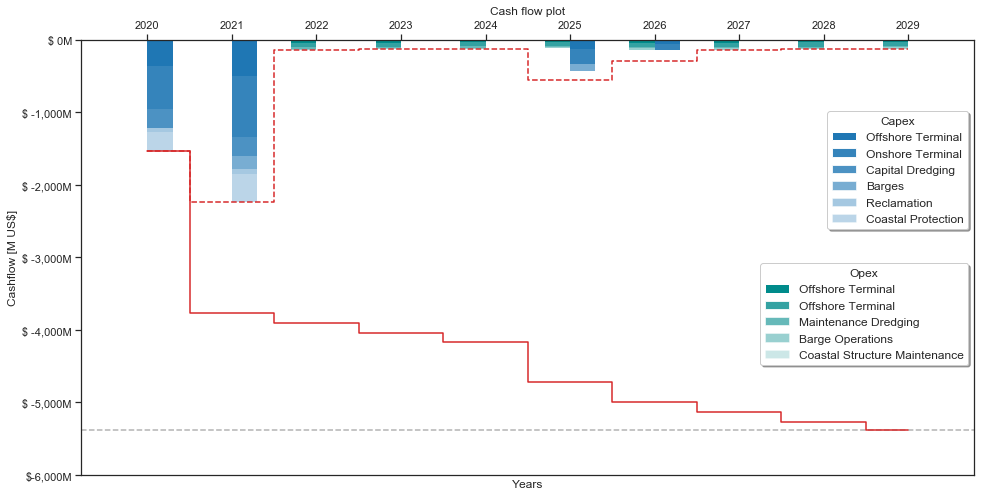

In [20]:
print('\033[1m Cash Flow Plot - Weighted average cost of capital \033[0m')
OffshoreBarge.cashflow_plot(cash_flows_WACC_real_df)

# # save fig
# # plt.savefig("SaveFigures/cash_flow_plot_WACC_ex2.png")

In [21]:
print('Offshore land use:')

for year in range(startyear, startyear + lifecycle):
    total_land_use = OffshoreBarge.calculate_land_use(year)
    print(round(total_land_use,1),'ha')

Offshore land use:
0 ha
0 ha
337475.8 ha
337475.8 ha
337475.8 ha
337475.8 ha
400943.0 ha
430843.7 ha
430843.7 ha
430843.7 ha


list of elements
                Element         Costs
3        Terminal Capex  1.038406e+09
1    Coastal Protection  6.591779e+08
5      Capital Dredging  5.319908e+08
4         Terminal Opex  2.825729e+08
8      Barge Investment  2.798724e+08
9     Barge Operartions  1.459540e+08
6  Maintenance Dredging  1.152631e+08
0           Reclamation  1.086557e+08
2         Island maint.  2.414540e+07
7       Ocean Transport  0.000000e+00


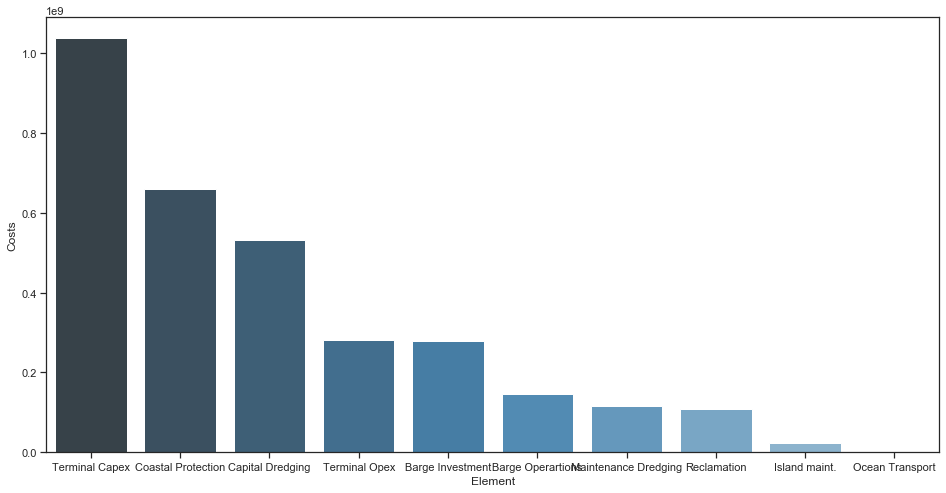

In [22]:
OffshoreBarge.element_cashflow_plot()

In [23]:
print("Offshore terminal capacity for initial demand:")
total_offshore_ground_slots, total_offshore_stack_capacity = OffshoreBarge.total_stack_capacity(2021)

total_offshore_ground_slots = round(total_offshore_ground_slots,-1)
total_offshore_stack_capacity = round(total_offshore_stack_capacity,-1)
      
%store total_offshore_ground_slots
%store total_offshore_stack_capacity

Offshore terminal capacity for initial demand:
     Total Ground Slots required (@ start of year):  3,265 TEU
     Total Stack capacity required (@ start of year):  17,287 TEU

Stored 'total_offshore_ground_slots' (float)
Stored 'total_offshore_stack_capacity' (float)


### Example figures

ValueError: shape mismatch: objects cannot be broadcast to a single shape

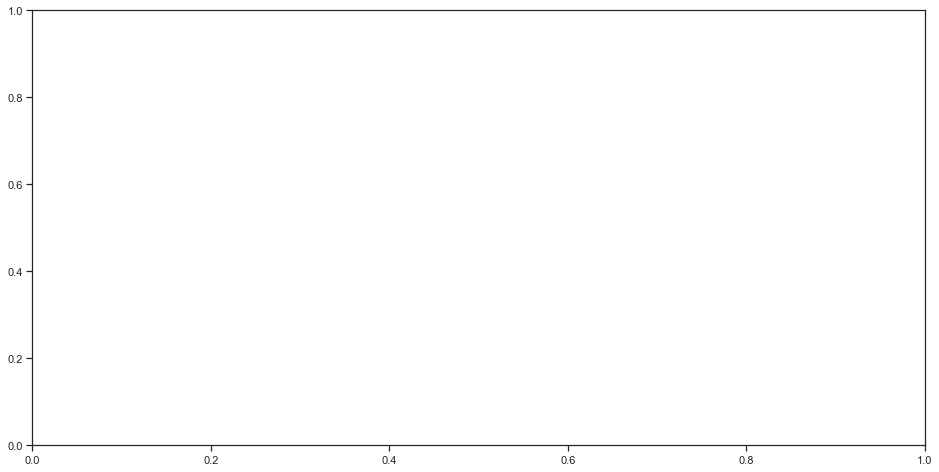

In [24]:
OffshoreBarge.ex_cashflow_plot(cash_flows_df)

# save fig
# plt.savefig("SaveFigures/ex_cashflow_plot.png")

In [ ]:
# store PV of the costs
demand = annual_demand.value

if offshore_distance == 40:  
    if design_container_ship == 12500:    
        if demand == 500000:
            print('The demand is 500_000')
            PV_alt2_40_12500_500000 = PV
            %store PV_alt2_40_12500_500000
        if demand == 1000000:
            print('The demand is 1_000_000')
            PV_alt2_40_12500_1000000 = PV
            %store PV_alt2_40_12500_1000000
        if demand == 1500000:
            print('The demand is 1_500_000')
            PV_alt2_40_12500_1500000 = PV
            %store PV_alt2_40_12500_1500000

In [ ]:
# store PV of the costs

if offshore_distance == 20:  
    if design_container_ship == 6000:
        PV_alt2_20_6000 = PV
        %store PV_alt2_20_6000
        
    if design_container_ship == 12500:
        PV_alt2_20_12500 = PV
        %store PV_alt2_20_12500
        
    if design_container_ship == 21000:
        PV_alt2_20_21000 = PV
        %store PV_alt2_20_21000
        
if offshore_distance == 40:  
    if design_container_ship == 6000:
        PV_alt2_40_6000 = PV
        %store PV_alt2_40_6000
        
    if design_container_ship == 12500:
        PV_alt2_40_12500 = PV
        %store PV_alt2_40_12500
        
    if design_container_ship == 21000:
        PV_alt2_40_21000 = PV
        %store PV_alt2_40_21000
        
if offshore_distance == 60:  
    if design_container_ship == 6000:
        PV_alt2_60_6000 = PV
        %store PV_alt2_60_6000
        
    if design_container_ship == 12500:
        PV_alt2_60_12500 = PV
        %store PV_alt2_60_12500
        
    if design_container_ship == 21000:
        PV_alt2_60_21000 = PV
        %store PV_alt2_60_21000

In [ ]:
PV_alt1_40_12500_500000  = -2.3e+09
PV_alt1_40_12500_1000000 = -2.4e+09
PV_alt1_40_12500_1500000 = -2.5e+09

PV_alt2_40_12500_500000  = -2.2e+09
PV_alt2_40_12500_1000000 = -2.35e+09
PV_alt2_40_12500_1500000 = -2.65e+09

PV_alt3_40_12500_500000  = -2.15e+09
PV_alt3_40_12500_1000000 = -2.45e+09
PV_alt3_40_12500_1500000 = -2.55e+09

%store PV_alt1_40_12500_500000 
%store PV_alt1_40_12500_1000000
%store PV_alt1_40_12500_1500000

%store PV_alt2_40_12500_500000 
%store PV_alt2_40_12500_1000000
%store PV_alt2_40_12500_1500000

%store PV_alt3_40_12500_500000 
%store PV_alt3_40_12500_1000000
%store PV_alt3_40_12500_1500000

In [ ]:
PV_alt1_40_12500_1000000_growth1 = -2.5e+09
PV_alt1_40_12500_1000000_growth2 = -2.7e+09
PV_alt1_40_12500_1000000_growth3 = -3.0e+09
PV_alt1_40_12500_1000000_growth4 = -3.7e+09

PV_alt2_40_12500_1000000_growth1 = -2.2e+09
PV_alt2_40_12500_1000000_growth2 = -3.0e+09
PV_alt2_40_12500_1000000_growth3 = -4.0e+09
PV_alt2_40_12500_1000000_growth4 = -4.8e+09

PV_alt3_40_12500_1000000_growth1 = -2.0e+09
PV_alt3_40_12500_1000000_growth2 = -3.0e+09
PV_alt3_40_12500_1000000_growth3 = -4.5e+09
PV_alt3_40_12500_1000000_growth4 = -5.8e+09

%store PV_alt1_40_12500_1000000_growth1
%store PV_alt1_40_12500_1000000_growth2
%store PV_alt1_40_12500_1000000_growth3
%store PV_alt1_40_12500_1000000_growth4

%store PV_alt2_40_12500_1000000_growth1
%store PV_alt2_40_12500_1000000_growth2
%store PV_alt2_40_12500_1000000_growth3
%store PV_alt2_40_12500_1000000_growth4

%store PV_alt3_40_12500_1000000_growth1
%store PV_alt3_40_12500_1000000_growth2
%store PV_alt3_40_12500_1000000_growth3
%store PV_alt3_40_12500_1000000_growth4

In [ ]:
PV_alt1_40_12500_1000000_slope1 = -1.2e+09
PV_alt1_40_12500_1000000_slope2 = -2.8e+09
PV_alt1_40_12500_1000000_slope3 = -6.6e+09

PV_alt2_40_12500_1000000_slope1 = -2.0e+09
PV_alt2_40_12500_1000000_slope2 = -3.0e+09
PV_alt2_40_12500_1000000_slope3 = -4.5e+09

PV_alt3_40_12500_1000000_slope1 = -2.8e+09
PV_alt3_40_12500_1000000_slope2 = -3.2e+09
PV_alt3_40_12500_1000000_slope3 = -4.9e+09

%store PV_alt1_40_12500_1000000_slope1
%store PV_alt1_40_12500_1000000_slope2
%store PV_alt1_40_12500_1000000_slope3

%store PV_alt2_40_12500_1000000_slope1
%store PV_alt2_40_12500_1000000_slope2
%store PV_alt2_40_12500_1000000_slope3

%store PV_alt3_40_12500_1000000_slope1
%store PV_alt3_40_12500_1000000_slope2
%store PV_alt3_40_12500_1000000_slope3

In [ ]:
PV_40_12500_1000000_downtime0 = -2.5e+09
PV_40_12500_1000000_downtime1 = -3.1e+09
PV_40_12500_1000000_downtime2 = -4.1e+09
PV_40_12500_1000000_downtime3 = -5.2e+09
PV_40_12500_1000000_downtime4 = -7.2e+09

%store PV_40_12500_1000000_downtime0
%store PV_40_12500_1000000_downtime1
%store PV_40_12500_1000000_downtime2
%store PV_40_12500_1000000_downtime3
%store PV_40_12500_1000000_downtime4
